# Emerging Technology Coding Challenge

In [1]:
"""
import all the libraries required
"""
import cv2
import dlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
from scipy import interpolate
from pylab import *
from skimage import color
from imutils import face_utils
import imutils

"""
Libraries required for running google api
"""
from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from __future__ import print_function
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.http import MediaIoBaseDownload
import io

In [2]:
"""
Code for pulling image from the google drive
"""

# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/drive']


"""Shows basic usage of the Drive v3 API.
Prints the names and ids of the first 10 files the user has access to.
"""
creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

service = build('drive', 'v3', credentials=creds)

# Call the Drive v3 API
results = service.files().list(
    pageSize=10, fields="nextPageToken, files(id, name)").execute()
items = results.get('files', [])

if not items:
    print('No files found.')
else:
    print('Files:')
    for item in items:
        print(u'{0} ({1})'.format(item['name'], item['id']))

Files:
benedict.jpg (1aBrIBFwaghhnJ2TTX7iCRqPcXAU2hqLH)
leonardo.jpg (1V4A5rphxtNe8WyNYc8A9dUrrhOpSL0sW)
nicolascage.jpg (1fHLTTMxx-KTJsRZywxFclrNR6ETQgPwJ)
georgeclooney.jpg (1Y4kr8bbn0Pox7AvWy5XUTht5wCB1vHvb)
Video Dataset Comparisons (14MJRAvkrthVk3TOyrXY2nwXogZpMEWsgUO7RlgCeST0)
Streaming CNN.ipynb (13pOVSsf3bfFONG-WqFMLCLgL2NpdoH6K)
gallagher insurance idcard.pdf (1rKos6kQipU2-noIW_waH71XwhNuaSo3G)
Test Instructions (1PJ4tVoxyFdile_NeAZKYFI-Ju0FF4HGHUWA5NfsDR80)
Hitesh's resume - 4.pdf (1cpUM-jHW32qKffaqF0EcEfhX3wxBqt9Z)
Hitesh's resume - 4.docx (1gXDJFokA_x6kfCkgO7MMvEnAFgGHDFgw)


In [3]:
# Select the corresponding file ID given within brackets for any image you wish to work on
file_id = '1aBrIBFwaghhnJ2TTX7iCRqPcXAU2hqLH'
request = service.files().get_media(fileId=file_id)
# fh = io.FileIO('image.jpg', mode='wb')
fh = io.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%.", int(status.progress() * 100))

Download %d%%. 100


<IPython.core.display.Javascript object>


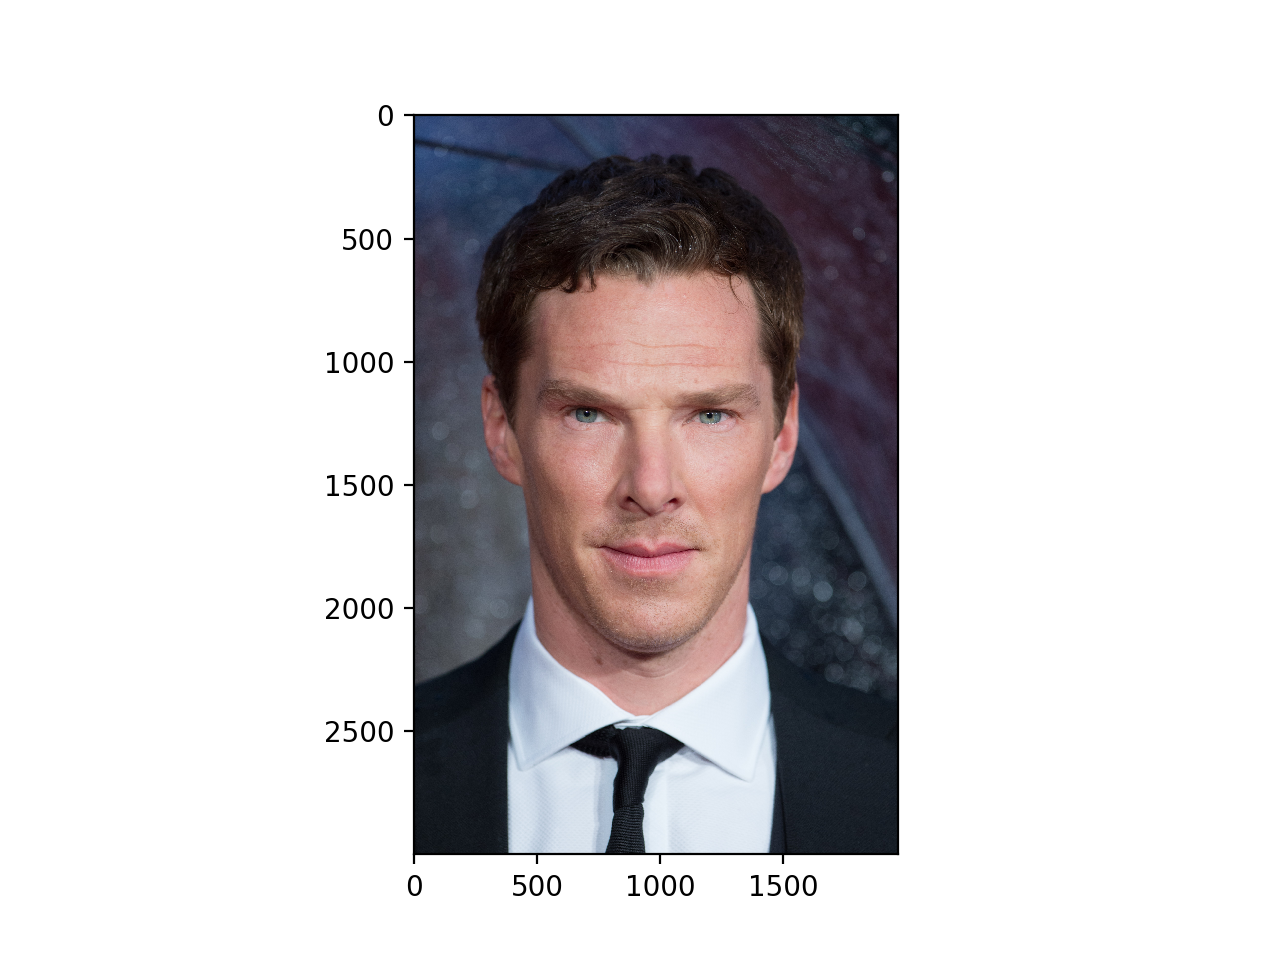

In [4]:
# image = cv2.imread('hitesh.JPG')
# image = np.array(Image.open(fh))

"""
The image downloaded is not saved locally. It is sent forward in the pipeline
"""
# convert the image data in bytes to numpy array
image = cv2.imdecode(np.frombuffer(fh.getvalue(), np.uint8), -1)
# convert the color scheme of the image obtained to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
%matplotlib notebook
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


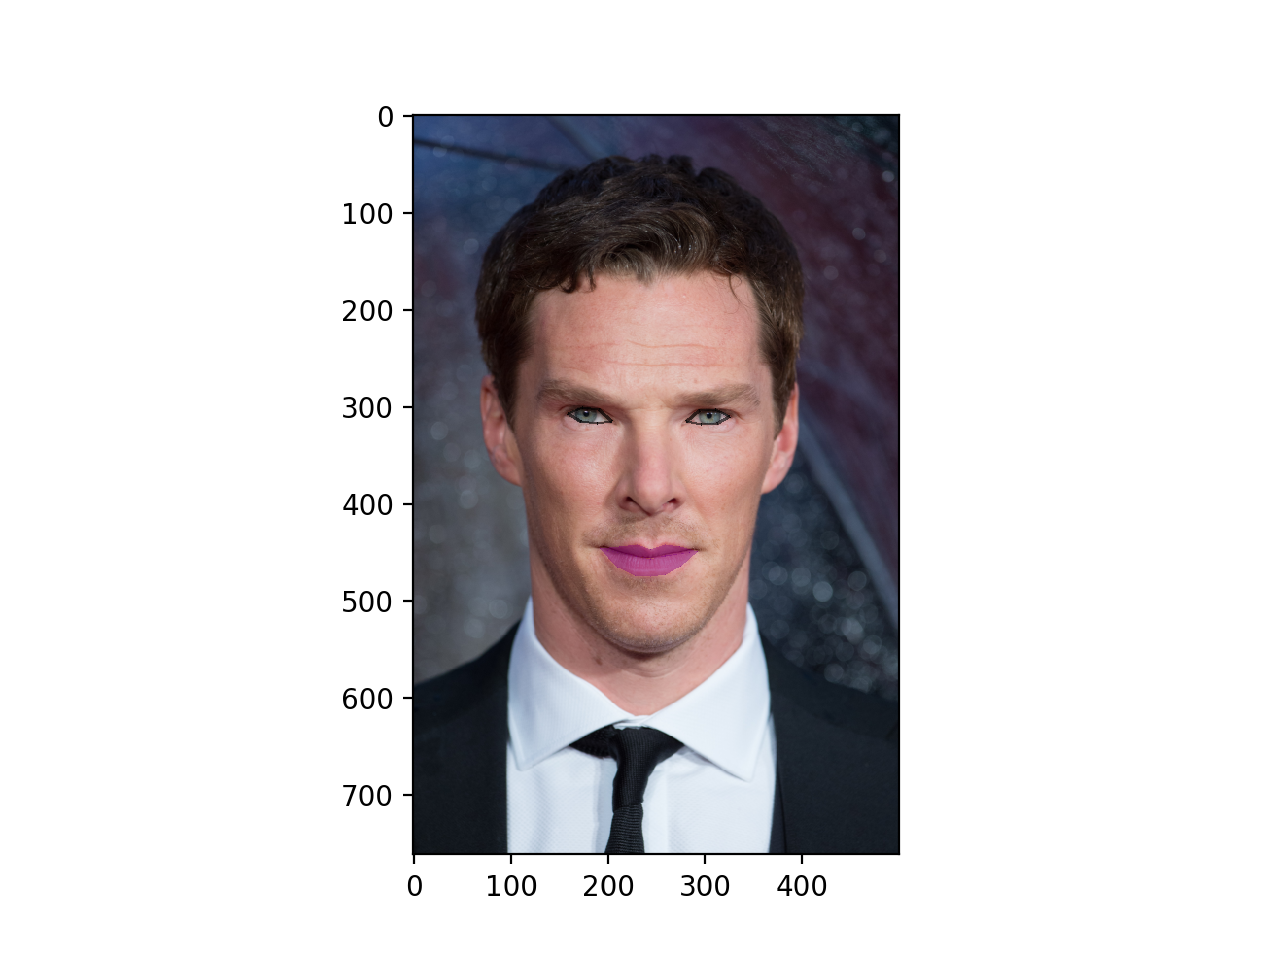

In [5]:
# resize the image
image = imutils.resize(image, width=500)

# convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

"""
we use, Histogram of Oriented Gradients (HOG)
to detect the interest points/landmark points
on the face
"""
hog_face_detector = dlib.get_frontal_face_detector()

"""
Another way to obtain interest points/landmark points
from the image is using CNN. However, it requires
more time to process
"""
cnn_face_detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')

"""
load the facial landmark predictor using the path to the
supplied predictor file
"""
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

"""
detect the face in grayscale image (works on normal image as well)
second parameter i.e. 1 is the number of image pyramid layers
to apply when upscaling the image prior to applying the detector
(this is equivalent to computing cv2.pyrup N number of times on
the image)
"""
faces = hog_face_detector(gray, 1)

# in case using CNN detector, use following line of code
# faces = cnn_face_detector(gray, 1)

"""
obtain the facial landmarks for the face in image,
then convert their coordinates to a numpy array
"""
shape = predictor(gray, faces[0])
shape = face_utils.shape_to_np(shape)
pil_image = Image.fromarray(image)

"""
create an ImageDraw object to draw on the image
RGBA allows us to control the transparency of
the colour
"""
d = ImageDraw.Draw(pil_image, 'RGBA')

"""
convert the numpy array containing facial landmark coordinates
in the form of tuples to a list of lists. eg:
array([(0, 1),    ->    [[0, 1],
       (2, 3)])          [2, 3]]
Reason: ImageDraw object (d), does not accept numpy array
while drawing shapes on the image
"""
shape = shape.tolist()
for i,j in enumerate(shape):
    shape[i] = (j[0], j[1])

# store indices of landmark points[0-67] to be used
indices = [48,49,50,51,52,53,54,64,63,62,61,60,48]
top_lip = [shape[i] for i in indices]
indices = [48,60,67,66,65,64,54,55,56,57,58,59,48]
bottom_lip = [shape[i] for i in indices]
indices = [36,37,38,39,40,41,36]
left_eye = [shape[i] for i in indices]
indices = [42,43,44,45,46,47,42]
right_eye = [shape[i] for i in indices]

# Draw the makeup on image
d.polygon(top_lip, fill=(128,0,128,100))
d.polygon(bottom_lip, fill=(128,0,128,100))
d.line(left_eye, fill=(0, 0, 0, 150), width=3)
d.line(right_eye, fill=(0, 0, 0, 150), width=3)

%matplotlib notebook
plt.imshow(pil_image)
plt.show()

In [6]:
# Color of blush on face
Rg, Gg, Bg = (223., 91., 111.)
pil_image = np.asarray(pil_image)
height, width = pil_image.shape[:2]
intensity = 0.5
imOrg = pil_image.copy()

"""
Get the boundary points of the blush on cheek
"""
def get_boundary_points(x, y):
    # interpolate i.e. obtain all the points between given vertice of polygon
    tck, u = interpolate.splprep([x, y], s=0, per=1)
    unew = np.linspace(u.min(), u.max(), 1000)
    xnew, ynew = interpolate.splev(unew, tck, der=0)
    tup = c_[xnew.astype(int), ynew.astype(int)].tolist()
    coord = list(set(tuple(map(tuple, tup))))
    coord = np.array([list(elem) for elem in coord])
    return np.array(coord[:, 0], dtype=np.int32), np.array(coord[:, 1], dtype=np.int32)

"""
Get all the points within selected polygon of blush
"""
def get_interior_points(x, y):
    intx = []
    inty = []

    """
    interior function to extend the list with points within 
    given range i.e. a to b
    """
    def ext(a, b, i):
        a, b = round(a), round(b)
        intx.extend(arange(a, b, 1).tolist())
        inty.extend((ones(b - a) * i).tolist())

    x, y = np.array(x), np.array(y)
    xmin, xmax = amin(x), amax(x)
    xrang = np.arange(xmin, xmax + 1, 1)
    for i in xrang:
        ylist = y[where(x == i)]
        ext(amin(ylist), amax(ylist), i)
    return np.array(intx, dtype=np.int32), np.array(inty, dtype=np.int32)

"""
Apply blush color on the face
"""
def apply_blush_color(r=Rg, g=Gg, b=Bg):
    global pil_image
    
    # normalize and change the intensities of pixels in 'LAB' color scheme
    val = color.rgb2lab((pil_image / 255.)).reshape(width * height, 3)
    L, A, B = mean(val[:, 0]), mean(val[:, 1]), mean(val[:, 2])
    L1, A1, B1 = color.rgb2lab(np.array((r / 255., g / 255., b / 255.)).reshape(1, 1, 3)).reshape(3, )
    ll, aa, bb = (L1 - L) * intensity, (A1 - A) * intensity, (B1 - B) * intensity
    val[:, 0] = np.clip(val[:, 0] + ll, 0, 100)
    val[:, 1] = np.clip(val[:, 1] + aa, -127, 128)
    val[:, 2] = np.clip(val[:, 2] + bb, -127, 128)
    
    # change the image array back to 'RGB' scheme
    pil_image = color.lab2rgb(val.reshape(height, width, 3)) * 255
    
"""
Smoothen the blush on cheek
"""
def smoothen_blush(x, y):
    global imOrg
    imgBase = zeros((height, width))
    
    """
    Fill the shape of blush with color
    c_() from pylab just zips two arrays index wise
    """
    cv2.fillConvexPoly(imgBase, np.array(c_[x, y], dtype='int32'), 1)
    # Blur the colour using GaussianBlur function
    imgMask = cv2.GaussianBlur(imgBase, (51, 51), 0)
    imgBlur3D = np.ndarray([height, width, 3], dtype='float')
    imgBlur3D[:, :, 0] = imgMask
    imgBlur3D[:, :, 1] = imgMask
    imgBlur3D[:, :, 2] = imgMask
    
    # Transform the image by adding blurred patch on cheek
    imOrg = (imgBlur3D * pil_image + (1 - imgBlur3D) * imOrg).astype('uint8')
#     return imgBase, np.array(c_[x, y], dtype='int32')

/Users/hitesh/anaconda3/envs/beautify/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][7]=x[0][0]
  (i, m, i)))
/Users/hitesh/anaconda3/envs/beautify/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][7]=x[1][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


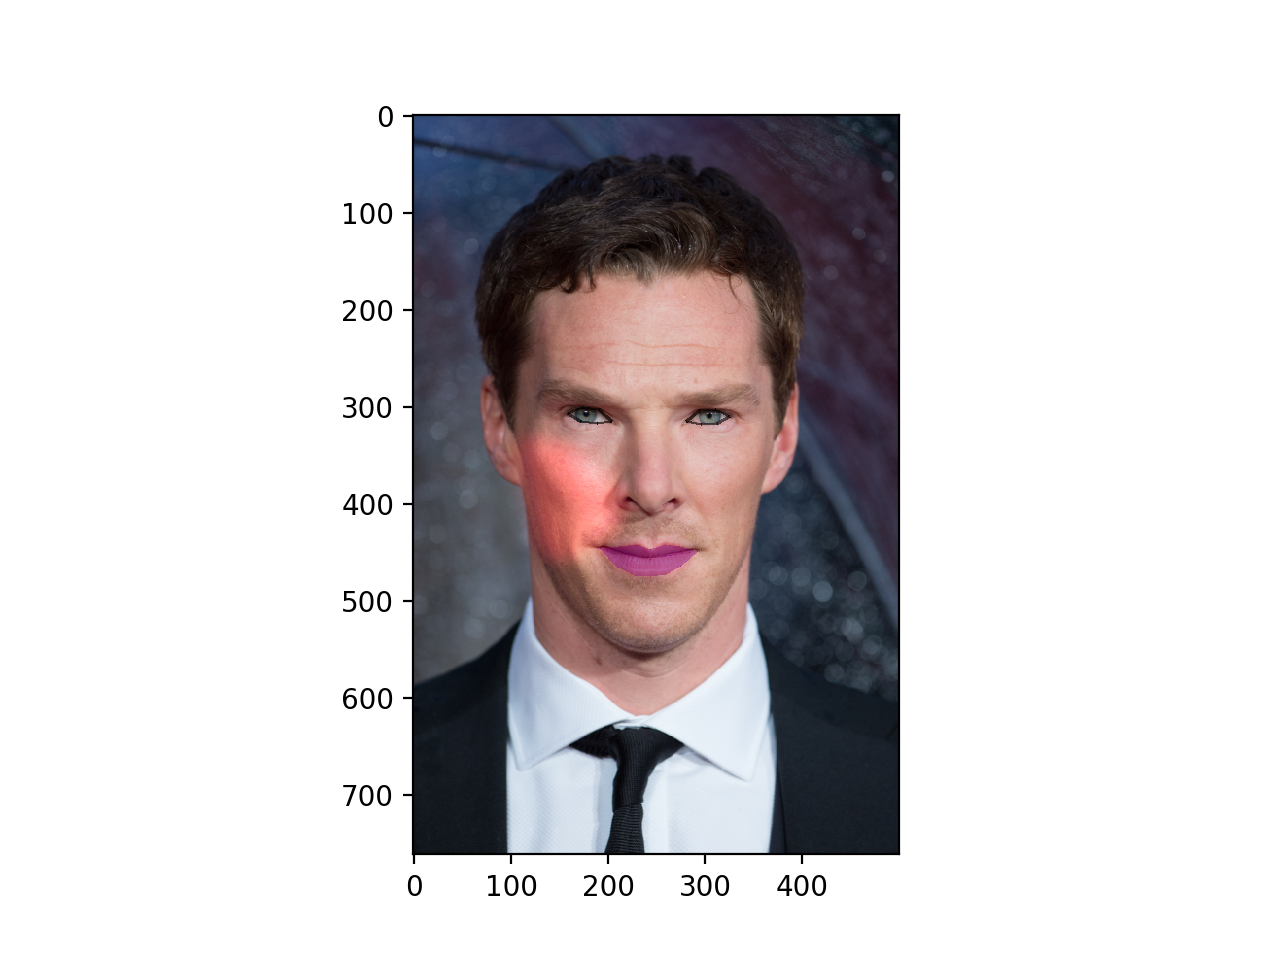

In [7]:
# select indices of landmark points for blush on left cheek
indices = [1,2,3,4,48,31,36]
left_cheek_x = [shape[i][0] for i in indices]
left_cheek_y = [shape[i][1] for i in indices]

# Get the pixel points within polygon and apply color on those points
left_cheek_x, left_cheek_y = get_boundary_points(left_cheek_x, left_cheek_y)
left_cheek_y, left_cheek_x = get_interior_points(left_cheek_x, left_cheek_y)
apply_blush_color()
smoothen_blush(left_cheek_x, left_cheek_y)
%matplotlib notebook
plt.imshow(imOrg)
plt.show()

/Users/hitesh/anaconda3/envs/beautify/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][7]=x[0][0]
  (i, m, i)))
/Users/hitesh/anaconda3/envs/beautify/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][7]=x[1][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


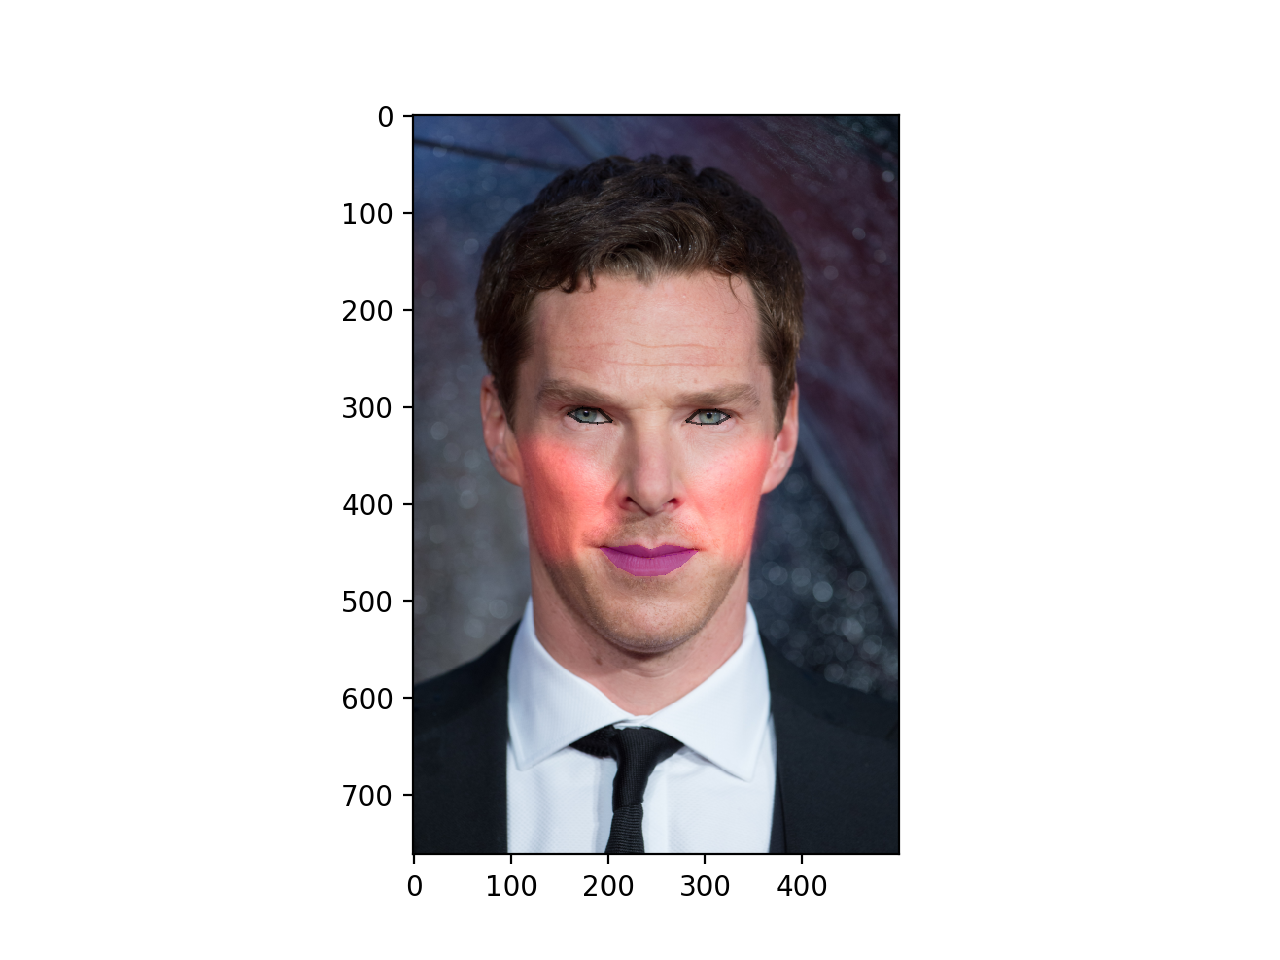

In [8]:
# select indices of landmark points for blush on right cheek
indices = [15,14,13,12,54,35,45]
right_cheek_x = [shape[i][0] for i in indices]
right_cheek_y = [shape[i][1] for i in indices]

# Get the pixel points within polygon and apply color on those points
right_cheek_x, right_cheek_y = get_boundary_points(right_cheek_x, right_cheek_y)
right_cheek_y, right_cheek_x = get_interior_points(right_cheek_x, right_cheek_y)
apply_blush_color()
smoothen_blush(right_cheek_x, right_cheek_y)
%matplotlib notebook
plt.imshow(imOrg)
plt.show()